# Mixed Domain

## Data

The pickle file contains a dictionary:
* x_<train/valid>: data point with 2 feature columns
* y_<train/valid>: label
* d_<train/valid>: domain

The train-valid split is:
* Train: 2400 datapoints
* Valid: 300 datapoints

In [1]:
import pickle
data = pickle.load(open("./data/data_d0.5.pkl", "rb"))

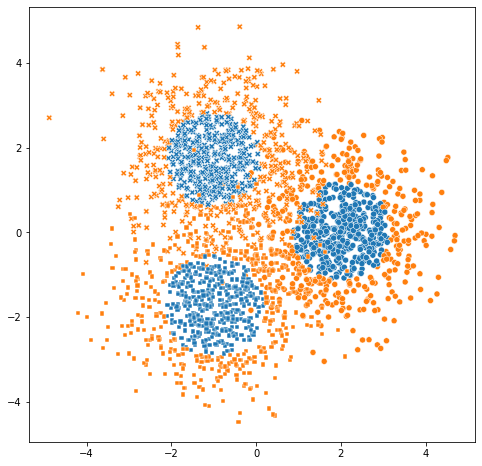

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.scatterplot(x=data['x_train'][:, 0], y=data['x_train'][:, 1],
                hue=data['y_train'], style=data['d_train'], legend=False
)

plt.show()

## Assignment Specifications

* Goal: To create a multi-domain FFNN of 2 hidden layers (20, 10) with ReLU as activation function.
* Report accuracy performance stats on validation set for random seeds [0, 10, 1234, 99, 2021].
* Train each model for 30,000 epochs using Adam optimizer (LR: 1e-3).


# Question 1: Implement a basic FNN (multi-domain model training)

INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.03126223012804985
INFO:util.loop:Validation loss: 0.2084086686372757
INFO:util.loop:Train acc: 99.00000%
INFO:util.loop:Validation acc: 98.00000%


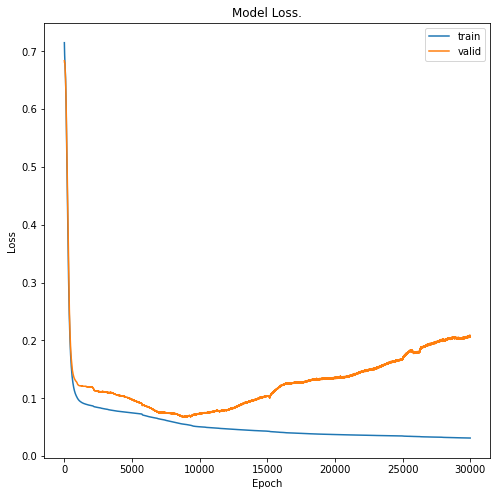

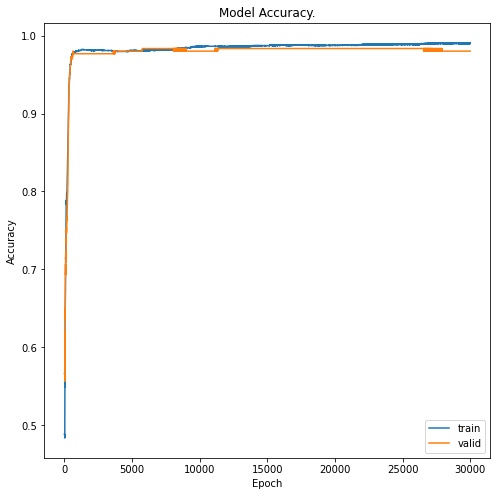

In [3]:
import torch
from util.model import FFNN
from util.loop import train

epochs = 30000
batch_size = 2400   # batch gradient descent
model = FFNN(random_state=0)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
model, _ = train(data, model, epochs, batch_size, optimizer, plot=True)



Random State 0:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.03126223012804985
INFO:util.loop:Validation loss: 0.2084086686372757
INFO:util.loop:Train acc: 99.00000%
INFO:util.loop:Validation acc: 98.00000%


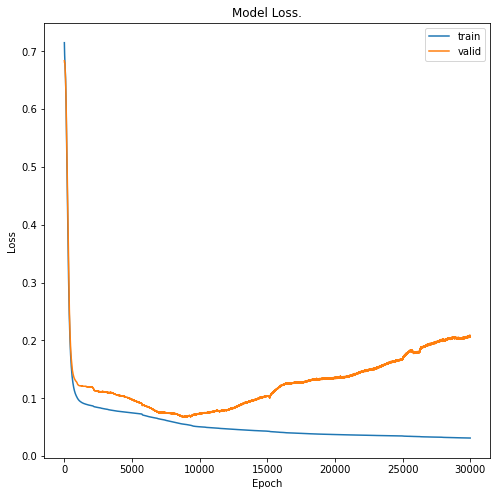

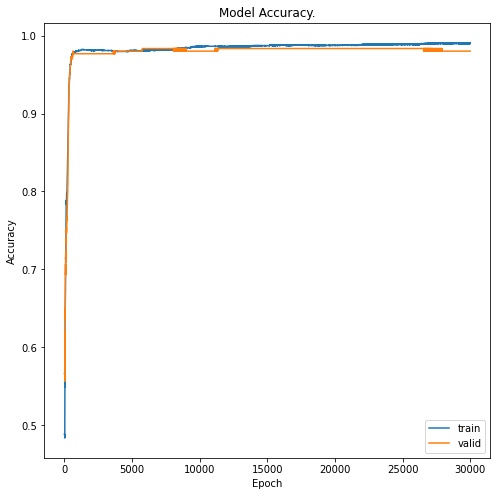



Random State 10:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.036625854671001434
INFO:util.loop:Validation loss: 0.23841528594493866
INFO:util.loop:Train acc: 98.66667%
INFO:util.loop:Validation acc: 97.66667%


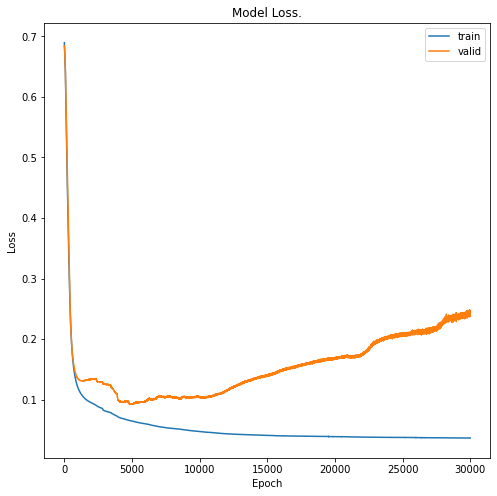

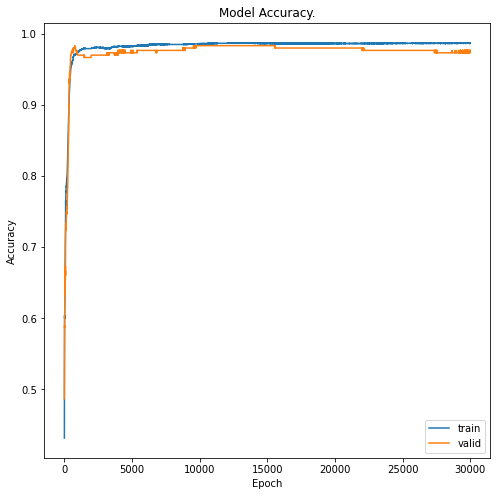



Random State 1234:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.04318416118621826
INFO:util.loop:Validation loss: 0.10811860859394073
INFO:util.loop:Train acc: 98.79167%
INFO:util.loop:Validation acc: 97.66667%


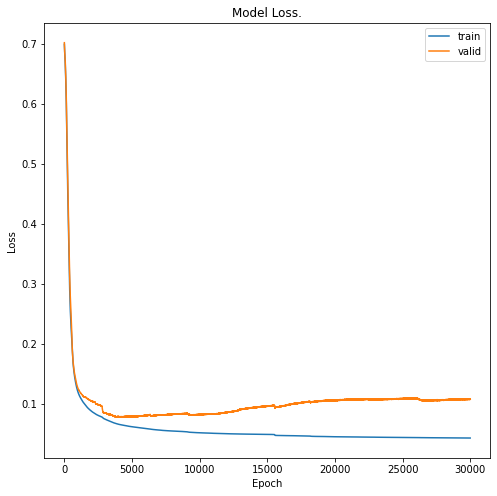

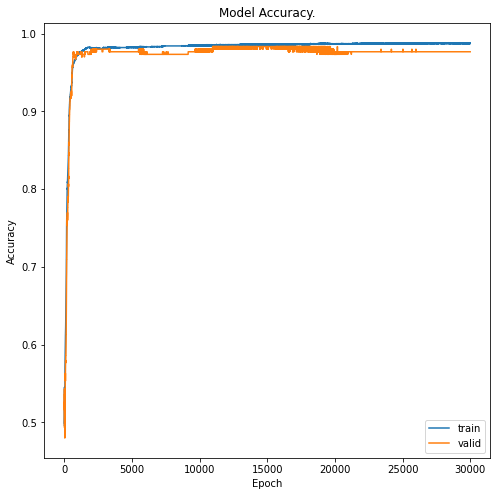



Random State 99:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.050908930599689484
INFO:util.loop:Validation loss: 0.09836743772029877
INFO:util.loop:Train acc: 98.83333%
INFO:util.loop:Validation acc: 98.00000%


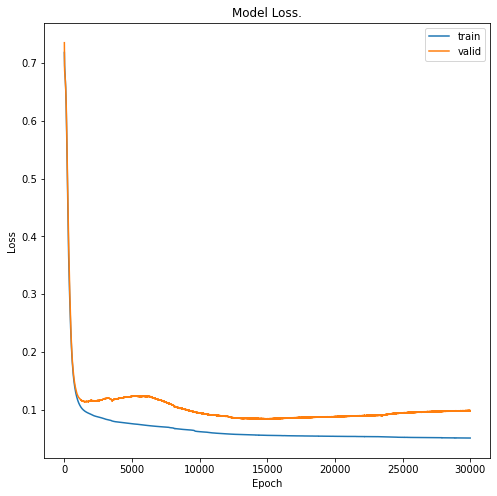

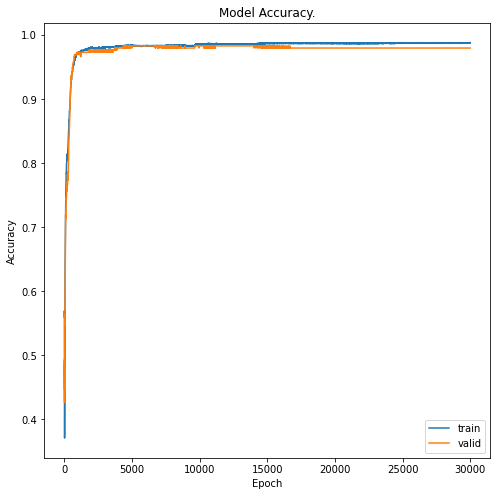



Random State 2021:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.03730068355798721
INFO:util.loop:Validation loss: 0.16776125133037567
INFO:util.loop:Train acc: 98.75000%
INFO:util.loop:Validation acc: 97.66667%


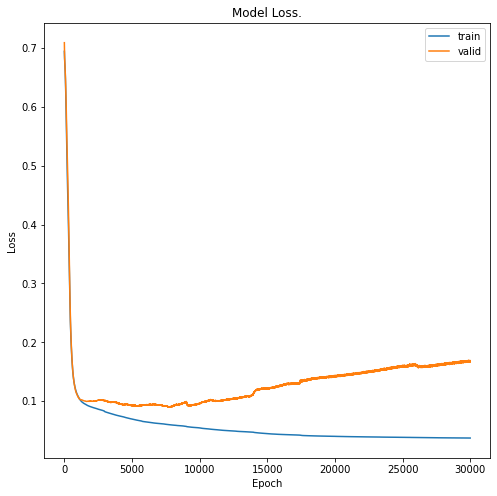

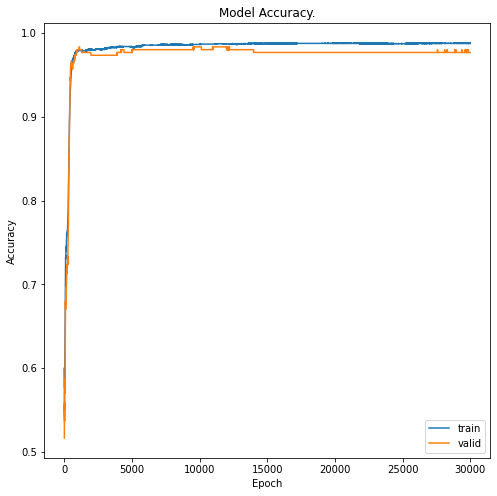

In [4]:
import torch
from util.model import FFNN
from util.loop import train

epochs = 30000
batch_size = 2400   # batch gradient descent
random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)
    print(f"\n\nRandom State {random_state}:")
    _, valid_acc = train(data, model, epochs, batch_size, optimizer, validate=True, plot=True, logfile=f"data0.5_q1_random_state_{random_state}")
    valid_accuracies.append(valid_acc)

In [5]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 97.800002% +/- 0.001825740117187435


# Creating a dictionary of different domain data

Needs to be created for the following questions.

In [3]:
Data = {}
for domain in set(data['d_train']):
    Data[domain] = {}
    for data_set in ['train', 'valid']:
        index = data[f'd_{data_set}']==domain
        for key in data.keys():
            if data_set in key: Data[domain][key] = data[key][index]

# Question 2: Implement a multi-domain model using knowledge distillation

## Teacher Model Training



 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.869022293656599e-06
INFO:util.loop:Validation loss: 0.18482522666454315
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%


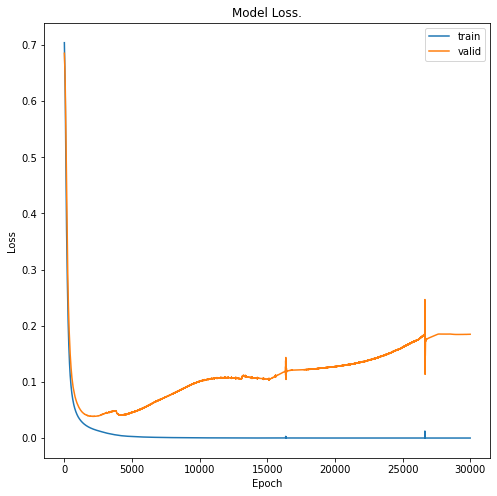

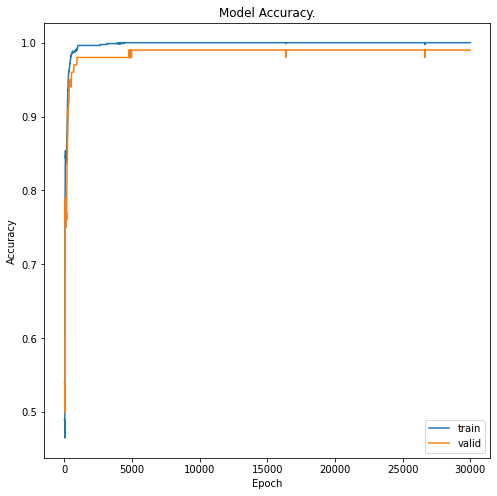



 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.0861621319312462e-09
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%


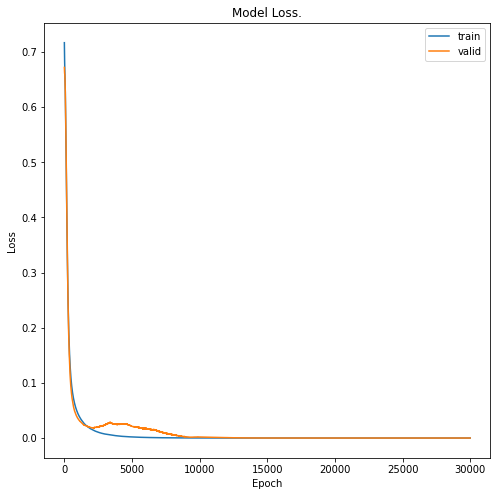

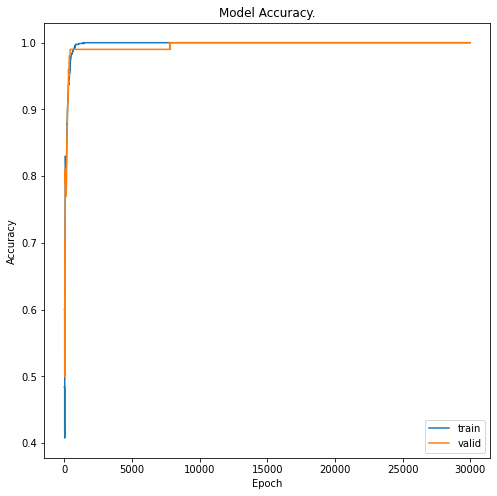



 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 8.344642310476047e-09
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%


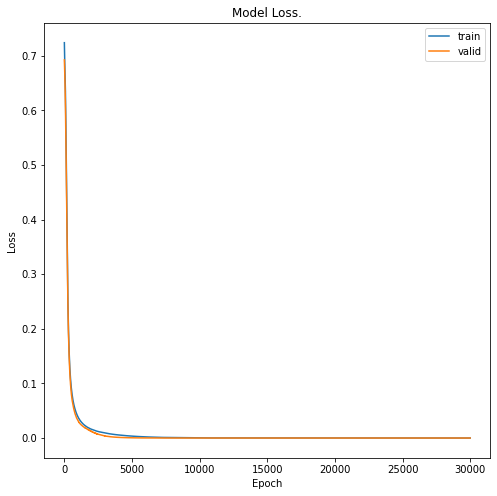

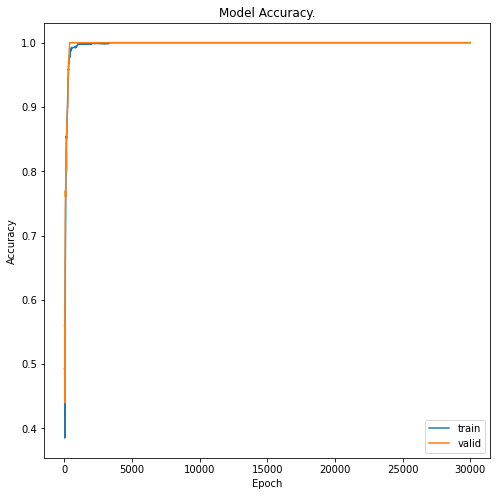

In [4]:
import torch
from util.model import FFNN
from util.loop import train

Teacher_Model = {}
for domain in set(data['d_train']):
    epochs = 30000
    batch_size = len(Data[domain]['x_train'])   # batch gradient descent
    Teacher_Model[domain] = FFNN(random_state=0)
    optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
    print(f"\n\n Teacher Model Training for Domain {domain}")
    Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, plot=True)

## Storing logits offline infered from trained teacher models

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for domain in set(data['d_train']):
    with torch.no_grad(): 
        Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
        Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

## Student Training

INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.343928575515747
INFO:util.loop:Validation loss: 3.102602005004883
INFO:util.loop:Train acc: 98.29167%
INFO:util.loop:Validation acc: 98.33333%


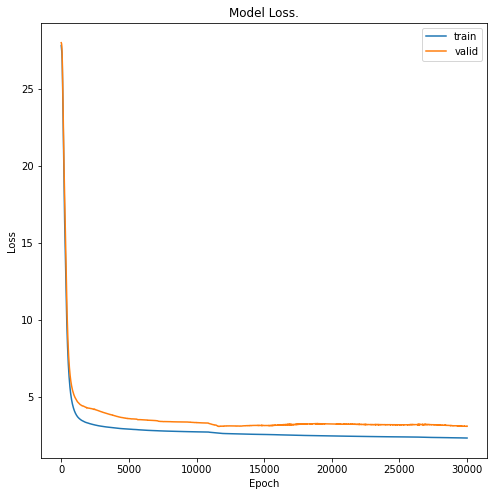

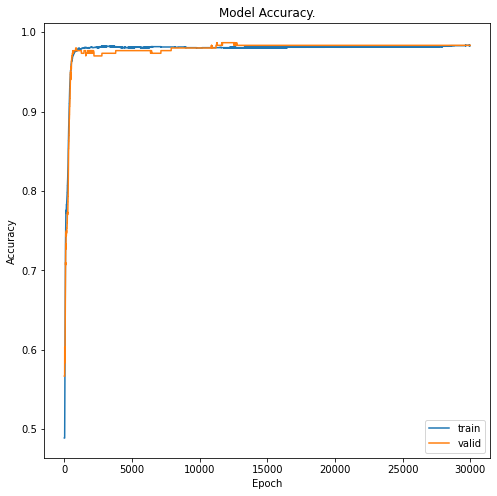

In [6]:
import torch
from util.model import FFNN
from util.loop import student_train

epochs = 30000
batch_size_ratio = 1.0   # batch gradient descent
alpha = 0.5
T = 9.0
Student_Model = FFNN(random_state=0)
optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
Student_Model, _ = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, plot=True)

## Complete run using 5 random states



 Teacher Model Training for Domain 0 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.869022293656599e-06
INFO:util.loop:Validation loss: 0.18482522666454315
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.0861621319312462e-09
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 8.344642310476047e-09
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.343928575515747
INFO:util.loop:Validation loss: 3.102602005004883
INFO:util.loop:Train acc: 98.29167%
INFO:util.loop:Validation acc: 98.33333%


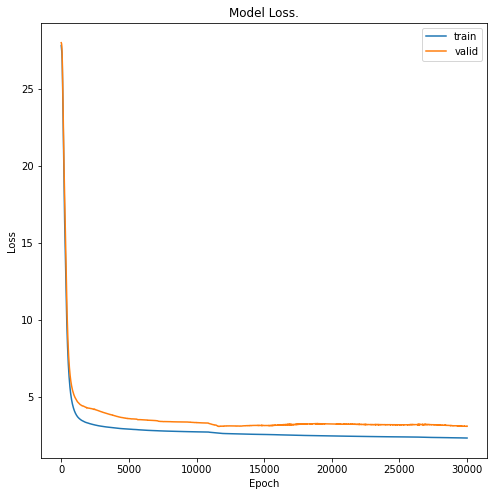

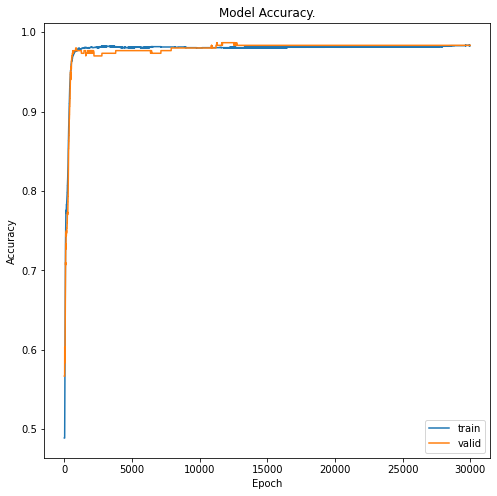



 Teacher Model Training for Domain 0 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.0359660740941763e-06
INFO:util.loop:Validation loss: 0.2233266979455948
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 4.947156284629273e-08
INFO:util.loop:Validation loss: 1.6689286397308933e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.3543764271494183e-08
INFO:util.loop:Validation loss: 1.1920927578401574e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.1542627811431885
INFO:util.loop:Validation loss: 3.844367265701294
INFO:util.loop:Train acc: 98.37499%
INFO:util.loop:Validation acc: 97.66666%


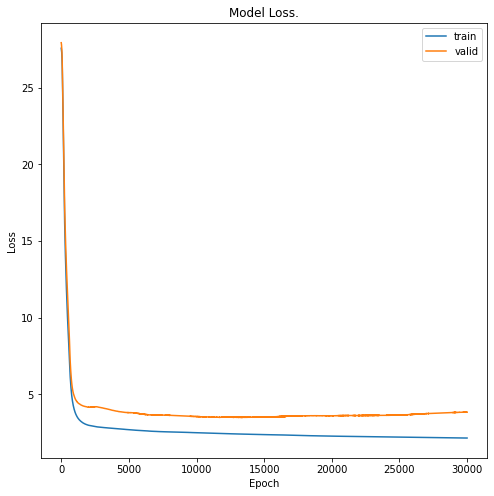

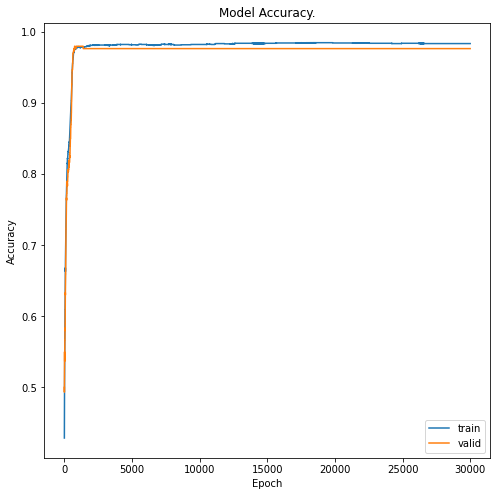



 Teacher Model Training for Domain 0 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 5.099069767311448e-06
INFO:util.loop:Validation loss: 0.29353874921798706
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.937150662101317e-09
INFO:util.loop:Validation loss: 0.19092528522014618
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 6.109472927562365e-09
INFO:util.loop:Validation loss: 0.0006076687714084983
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.9741674661636353
INFO:util.loop:Validation loss: 2.6390740871429443
INFO:util.loop:Train acc: 98.45833%
INFO:util.loop:Validation acc: 98.00000%


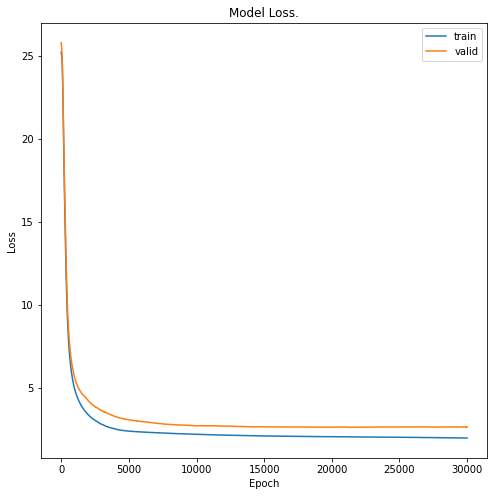

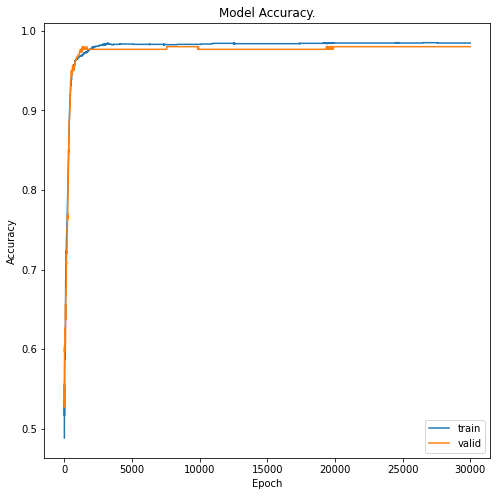



 Teacher Model Training for Domain 0 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.773741127588437e-06
INFO:util.loop:Validation loss: 0.23284561932086945
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.2351738238057806e-09
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.412355198406658e-08
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.9978246688842773
INFO:util.loop:Validation loss: 3.153437852859497
INFO:util.loop:Train acc: 98.75000%
INFO:util.loop:Validation acc: 98.33333%


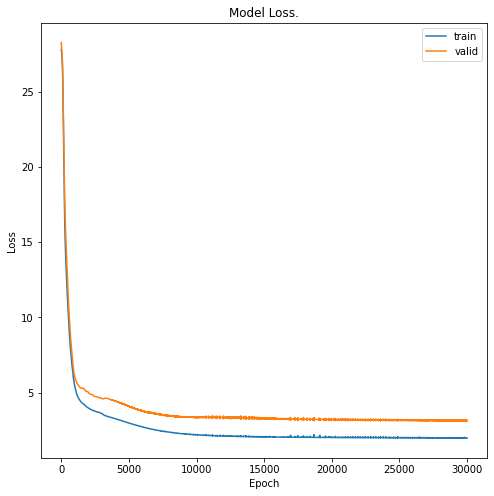

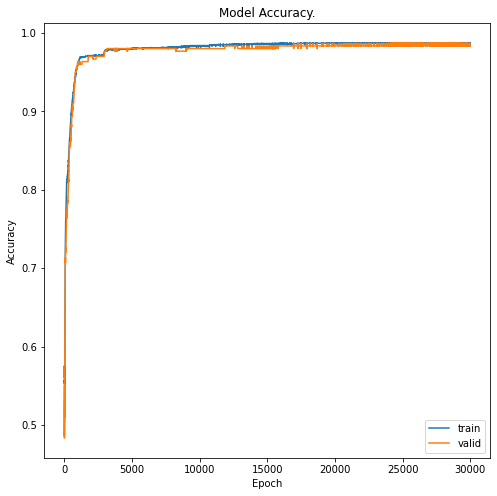



 Teacher Model Training for Domain 0 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.7476517086834065e-06
INFO:util.loop:Validation loss: 3.486263949525892e-06
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.3411043386923893e-09
INFO:util.loop:Validation loss: 0.061183009296655655
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.205937562393956e-06
INFO:util.loop:Validation loss: 0.15906654298305511
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Student Model Training [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.2084193229675293
INFO:util.loop:Validation loss: 3.1328818798065186
INFO:util.loop:Train acc: 98.29167%
INFO:util.loop:Validation acc: 97.66666%


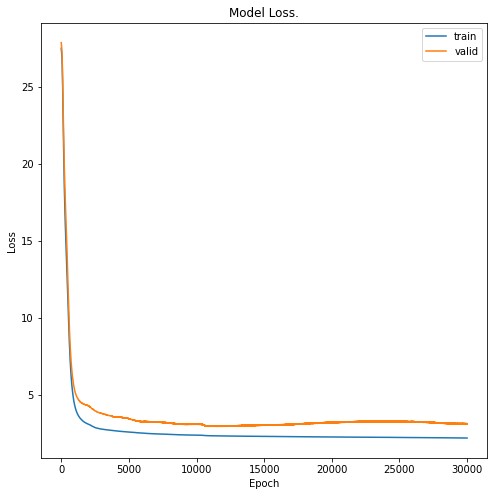

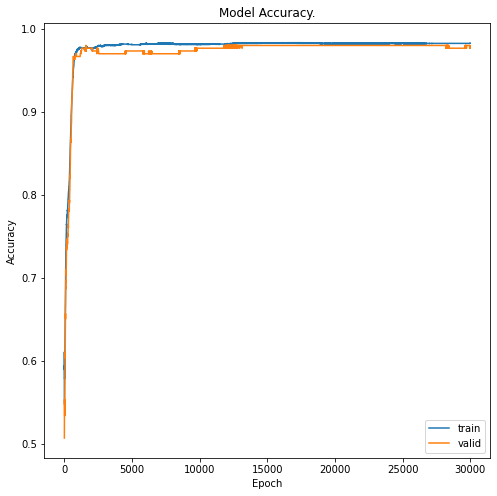

In [7]:
import torch
from util.model import FFNN
from util.loop import train, student_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:

    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain} [Random State {random_state}]")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, 
                                         plot=False, logfile=f"data0.5_q2_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.5
    T = 9.0
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training [Random State {random_state}]")
    Student_Model, valid_acc = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, 
                                             plot=True, logfile=f"data0.5_q2_student_random_state_{random_state}")

    valid_accuracies.append(valid_acc)

In [8]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 97.999996% +/- 0.0033333301544189453


# Question 3: Ways to improve

## Method 1: Tuning and Checkpointing best model.

Tuning alpha value to shift weightage between soft label training and hard label training. Early stopping at least validation loss checkpoint for the teacher and student also helps improving the final results.



 Teacher Model Training for Domain 0 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 2129 based on val_loss
INFO:util.loop:Train loss: 0.01592601276934147
INFO:util.loop:Validation loss: 0.03854644298553467
INFO:util.loop:Train acc: 99.62500%
INFO:util.loop:Validation acc: 98.00000%




 Teacher Model Training for Domain 1 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 20807 based on val_loss
INFO:util.loop:Train loss: 1.5437467482115608e-07
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 17172 based on val_loss
INFO:util.loop:Train loss: 5.4330844250216614e-06
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 0]


INFO:util.loop:
Checkpoint Epoch 29870 based on val_loss
INFO:util.loop:Train loss: 2.407377004623413
INFO:util.loop:Validation loss: 3.3190250396728516
INFO:util.loop:Train acc: 98.16666%
INFO:util.loop:Validation acc: 98.00000%


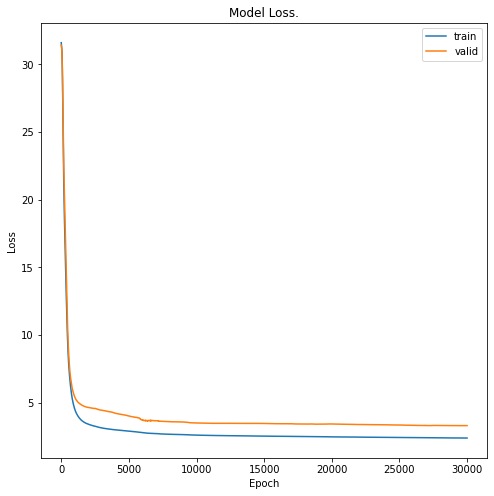

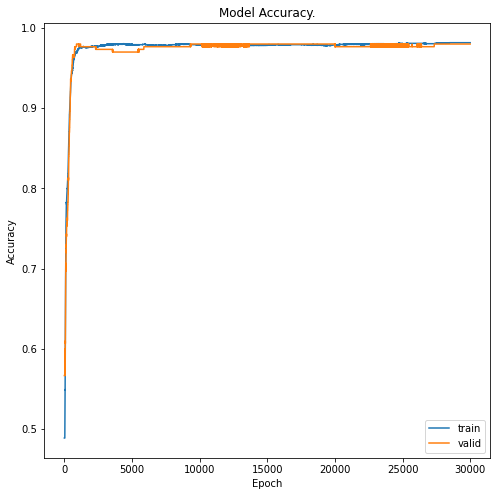



 Teacher Model Training for Domain 0 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 13894 based on val_loss
INFO:util.loop:Train loss: 0.00011457100481493399
INFO:util.loop:Validation loss: 0.006031644064933062
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 22740 based on val_loss
INFO:util.loop:Train loss: 1.5035132605589752e-07
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 27108 based on val_loss
INFO:util.loop:Train loss: 1.7359373316594429e-07
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 10]


INFO:util.loop:
Checkpoint Epoch 14929 based on val_loss
INFO:util.loop:Train loss: 3.245786666870117
INFO:util.loop:Validation loss: 4.106873989105225
INFO:util.loop:Train acc: 98.29166%
INFO:util.loop:Validation acc: 98.00000%


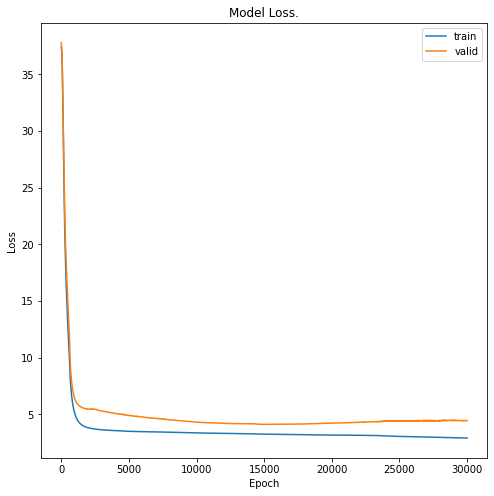

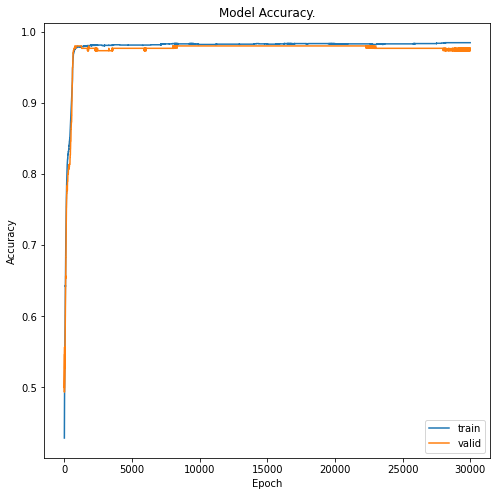



 Teacher Model Training for Domain 0 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 2649 based on val_loss
INFO:util.loop:Train loss: 0.007480572443455458
INFO:util.loop:Validation loss: 0.02438669092953205
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 1526 based on val_loss
INFO:util.loop:Train loss: 0.027403339743614197
INFO:util.loop:Validation loss: 0.021665124222636223
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 17871 based on val_loss
INFO:util.loop:Train loss: 8.138438715832308e-06
INFO:util.loop:Validation loss: 8.462149708066136e-06
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 8291 based on val_loss
INFO:util.loop:Train loss: 1.471117615699768
INFO:util.loop:Validation loss: 1.3671177625656128
INFO:util.loop:Train acc: 97.66667%
INFO:util.loop:Validation acc: 98.00000%


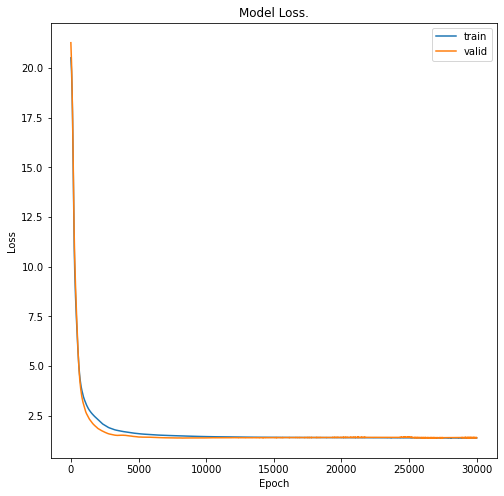

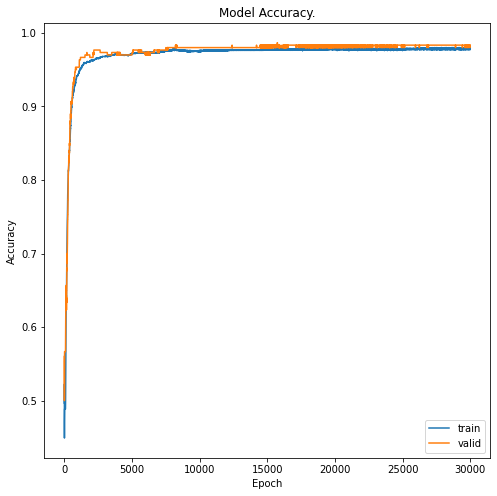



 Teacher Model Training for Domain 0 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 5932 based on val_loss
INFO:util.loop:Train loss: 0.001601697877049446
INFO:util.loop:Validation loss: 0.008870471268892288
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 18972 based on val_loss
INFO:util.loop:Train loss: 5.245058218861232e-07
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 15005 based on val_loss
INFO:util.loop:Train loss: 1.2527133549156133e-05
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 99]


INFO:util.loop:
Checkpoint Epoch 29972 based on val_loss
INFO:util.loop:Train loss: 3.304811477661133
INFO:util.loop:Validation loss: 3.929612398147583
INFO:util.loop:Train acc: 98.04166%
INFO:util.loop:Validation acc: 98.33333%


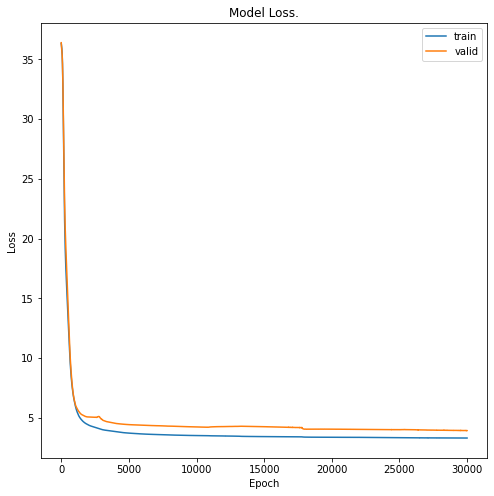

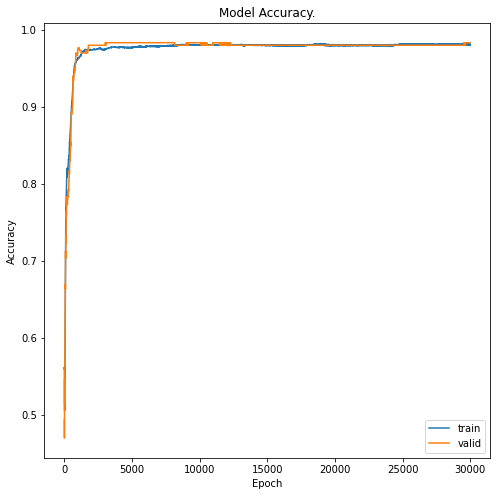



 Teacher Model Training for Domain 0 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 29066 based on val_loss
INFO:util.loop:Train loss: 0.008170291781425476
INFO:util.loop:Validation loss: 1.4305109097279e-08
INFO:util.loop:Train acc: 99.62500%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 2140 based on val_loss
INFO:util.loop:Train loss: 0.012637580744922161
INFO:util.loop:Validation loss: 0.018497327342629433
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 10758 based on val_loss
INFO:util.loop:Train loss: 0.0011049596359953284
INFO:util.loop:Validation loss: 1.902092481032014e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 29929 based on val_loss
INFO:util.loop:Train loss: 2.4171745777130127
INFO:util.loop:Validation loss: 2.1196441650390625
INFO:util.loop:Train acc: 98.04166%
INFO:util.loop:Validation acc: 98.33333%


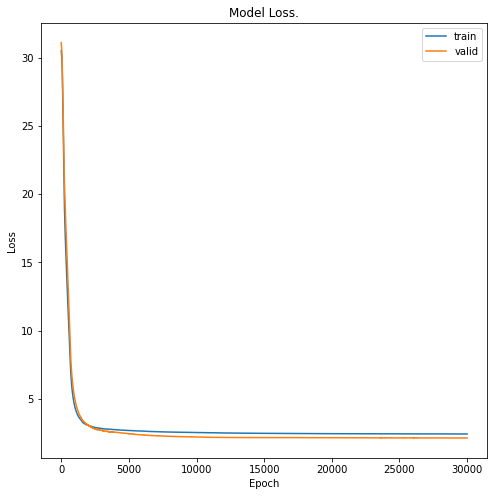

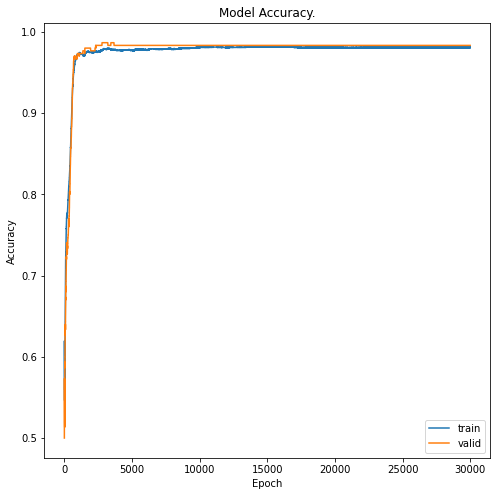

In [9]:
import torch
from util.model import FFNN
from util.loop import train, student_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain} [Random State {random_state}]")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, checkpoint_val_best="loss", 
                                         plot=False, logfile=f"data0.5_q31_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.69
    T = 9.0
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training [Random State {random_state}]")
    Student_Model, valid_acc = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T,  checkpoint_val_best="loss",
                                             plot=True, logfile=f"data0.5_q31_student_random_state_{random_state}")

    valid_accuracies.append(valid_acc)

In [10]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 98.133329% +/- 0.001825740117187435


## Method 2: Annealing Knowledge Distillation

Annealing temperature value would allow the student to learn from flatter convex curvatures (non-convex here considered as a combination of convex landscapes), there by starting from a reduced differences in the multiple domain functions, i.e., adapting from the common feature learning.

The solution is adapted from the following reference. Instead of training with annealing T=1 steps and then fine-tuning with CE, alpha weighting is implemented to do it simultaneously.

_Ref: Jafari, A., Rezagholizadeh, M., Sharma, P. and Ghodsi, A., 2021, April. Annealing Knowledge Distillation. 
       In Proceedings of the 16th Conference of the European Chapter of the Association for Computational Linguistics: 
       Main Volume (pp. 2493-2504)._



 Teacher Model Training for Domain 0 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 2129 based on val_loss
INFO:util.loop:Train loss: 0.01592601276934147
INFO:util.loop:Validation loss: 0.03854644298553467
INFO:util.loop:Train acc: 99.62500%
INFO:util.loop:Validation acc: 98.00000%




 Teacher Model Training for Domain 1 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 20807 based on val_loss
INFO:util.loop:Train loss: 1.5437467482115608e-07
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 17172 based on val_loss
INFO:util.loop:Train loss: 5.4330844250216614e-06
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 0]


INFO:util.loop:
Checkpoint Epoch 29916 based on val_loss
INFO:util.loop:Train loss: 20781.236328125
INFO:util.loop:Validation loss: 37801.99609375
INFO:util.loop:Train acc: 90.04166%
INFO:util.loop:Validation acc: 90.33334%


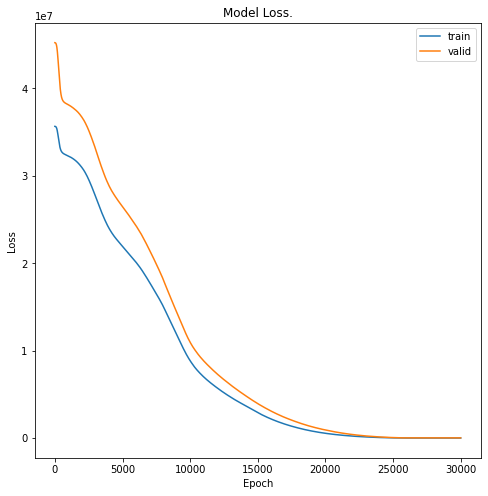

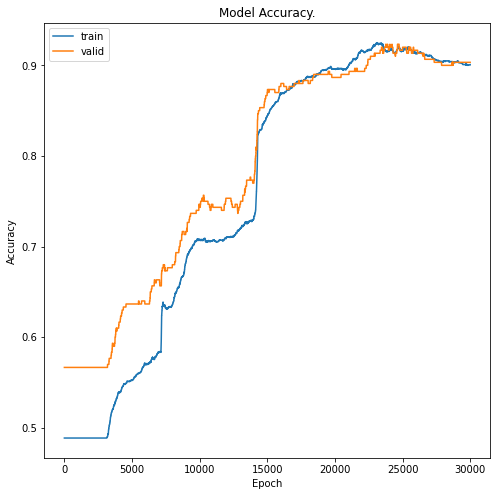



 Teacher Model Training for Domain 0 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 13894 based on val_loss
INFO:util.loop:Train loss: 0.00011457100481493399
INFO:util.loop:Validation loss: 0.006031644064933062
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 22740 based on val_loss
INFO:util.loop:Train loss: 1.5035132605589752e-07
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 27108 based on val_loss
INFO:util.loop:Train loss: 1.7359373316594429e-07
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 10]


INFO:util.loop:
Checkpoint Epoch 29773 based on val_loss
INFO:util.loop:Train loss: 18746.75
INFO:util.loop:Validation loss: 36272.578125
INFO:util.loop:Train acc: 91.62500%
INFO:util.loop:Validation acc: 92.66667%


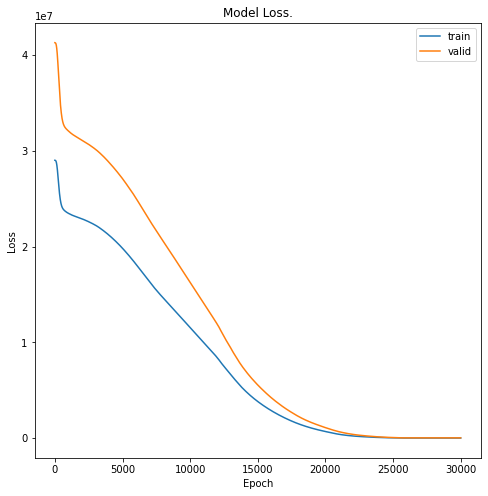

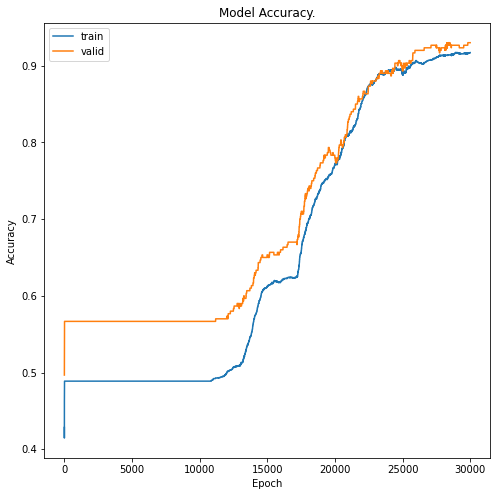



 Teacher Model Training for Domain 0 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 2649 based on val_loss
INFO:util.loop:Train loss: 0.007480572443455458
INFO:util.loop:Validation loss: 0.02438669092953205
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 1526 based on val_loss
INFO:util.loop:Train loss: 0.027403339743614197
INFO:util.loop:Validation loss: 0.021665124222636223
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 17871 based on val_loss
INFO:util.loop:Train loss: 8.138438715832308e-06
INFO:util.loop:Validation loss: 8.462149708066136e-06
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 30000 based on val_loss
INFO:util.loop:Train loss: 7309.755859375
INFO:util.loop:Validation loss: 14981.7041015625
INFO:util.loop:Train acc: 79.41666%
INFO:util.loop:Validation acc: 80.33333%


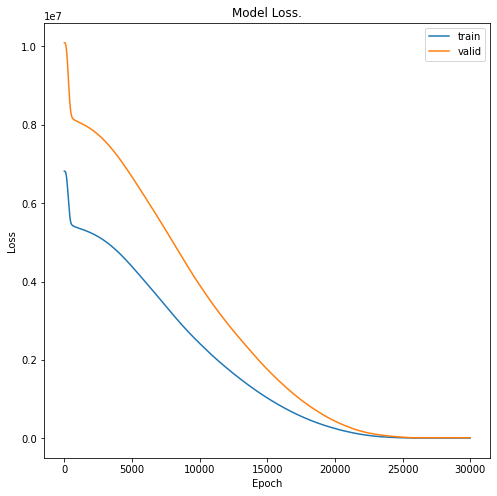

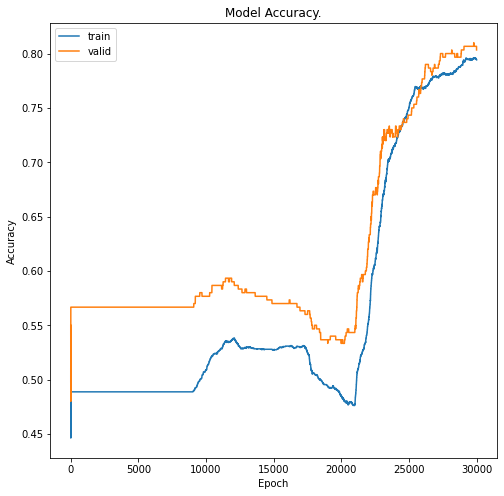



 Teacher Model Training for Domain 0 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 5932 based on val_loss
INFO:util.loop:Train loss: 0.001601697877049446
INFO:util.loop:Validation loss: 0.008870471268892288
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 18972 based on val_loss
INFO:util.loop:Train loss: 5.245058218861232e-07
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 15005 based on val_loss
INFO:util.loop:Train loss: 1.2527133549156133e-05
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 99]


INFO:util.loop:
Checkpoint Epoch 27128 based on val_loss
INFO:util.loop:Train loss: 24831.048828125
INFO:util.loop:Validation loss: 46042.98828125
INFO:util.loop:Train acc: 86.20833%
INFO:util.loop:Validation acc: 83.66666%


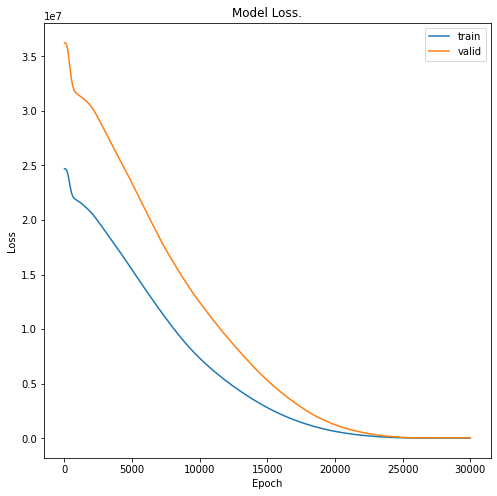

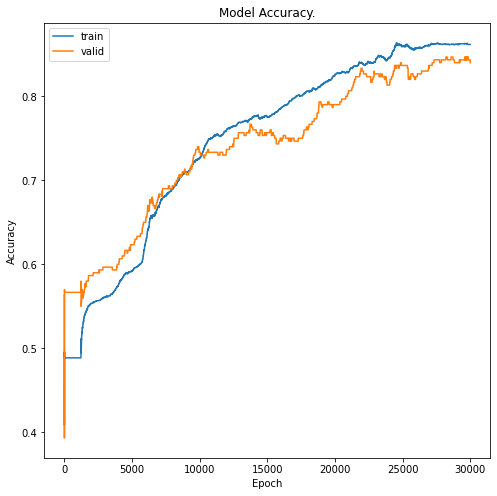



 Teacher Model Training for Domain 0 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 29066 based on val_loss
INFO:util.loop:Train loss: 0.008170291781425476
INFO:util.loop:Validation loss: 1.4305109097279e-08
INFO:util.loop:Train acc: 99.62500%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 2140 based on val_loss
INFO:util.loop:Train loss: 0.012637580744922161
INFO:util.loop:Validation loss: 0.018497327342629433
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 10758 based on val_loss
INFO:util.loop:Train loss: 0.0011049596359953284
INFO:util.loop:Validation loss: 1.902092481032014e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 30000 based on val_loss
INFO:util.loop:Train loss: 12836.328125
INFO:util.loop:Validation loss: 11600.96484375
INFO:util.loop:Train acc: 82.16667%
INFO:util.loop:Validation acc: 80.00000%


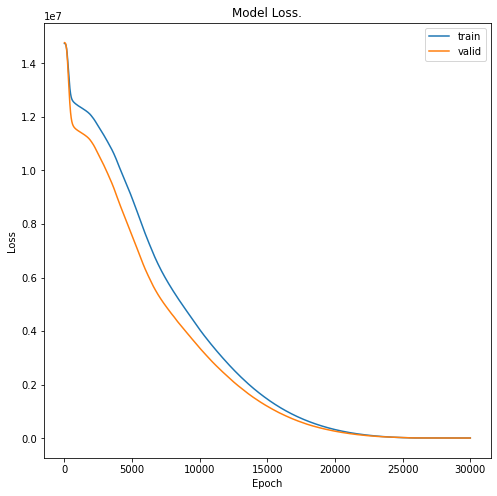

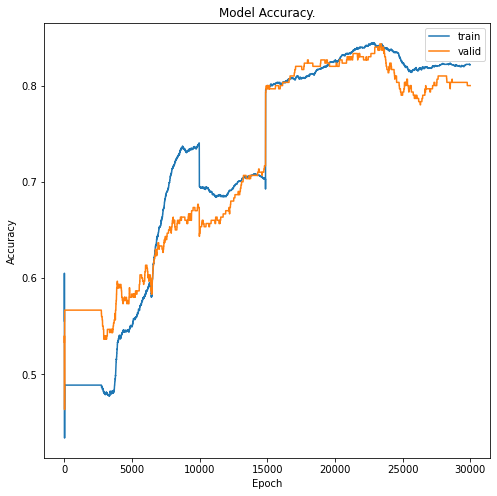

In [4]:
import torch
from util.model import FFNN
from util.loop import train, student_train_KD_annealing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain} [Random State {random_state}]")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, checkpoint_val_best="loss", 
                                         plot=False, logfile=f"data0.5_q32_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Annealing Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.81
    T_max = 18
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training [Random State {random_state}]")
    Student_Model, valid_acc = student_train_KD_annealing(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T_max, checkpoint_val_best="loss",
                                                          plot=True, logfile=f"data0.5_q32_student_random_state_{random_state}_{T_max}")

    valid_accuracies.append(valid_acc)

In [5]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 85.400000% +/- 0.058089988724000736
